## DCL CoCo Bonds

The following code imports data exported from Reuters, then uses it to model DCL CoCo bonds. 

In [47]:
"""
TODO: Add AT1 bond data
TODO: Add CET1 ratio data
TODO: Add shares outstanding data (NS_{k-1})
TODO: Calculate market caps

TODO: Find risk free rates (Yield curve?)
TODO: Derive the following from the data:
    RQ_k = Q * ((1 + r)^k + (1 - (1 + r)^k)/(1 - (1 + r)^{-N_m})) # Note that this only applies if the triggers are not breached
    Leverage ratio = Total debt / (Total equity + Total debt) = RQ_k / (RQ_k + NS_{k-1} * S_k)
    alpha = RQ_k / (RQ_k + Book value of non CoCo debt)
"""

'\nTODO: Add AT1 bond data\nTODO: Add CET1 ratio data\nTODO: Add shares outstanding data (NS_{k-1})\nTODO: Calculate market caps\n\nTODO: Find risk free rates (Yield curve?)\nTODO: Derive the following from the data:\n    RQ_k = Q * ((1 + r)^k + (1 - (1 + r)^k)/(1 - (1 + r)^{-N_m})) # Note that this only applies if the triggers are not breached\n    Leverage ratio = Total debt / (Total equity + Total debt) = RQ_k / (RQ_k + NS_{k-1} * S_k)\n    alpha = RQ_k / (RQ_k + Book value of non CoCo debt)\n'

In [48]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [49]:
# ================================================================
#                         Model Parameters
# ================================================================

ticker = "CSGN.S"   # Credit Suisse
# ticker = "DBKGn.DE" # Deutsche Bank
# ticker = "LEHMQ.PK" # Lehman Brothers
# ticker = "SVBQ.PK"  # Silicon Valley Bank

T = 10       # Number of years to maturity for DCL bonds
r = 0.05     # Risk free rate
L_min = 0.20 # Minimum leverage ratio
L_c = 0.8    # Critical leverage ratio


In [50]:
# ================================================================
#                     Load data from Reuters
# ================================================================

def load_reuters_data(ticker, data_folder = "data/reuterseikonexports") -> pd.DataFrame: 
    """
    Stock price data exported from Reuters Eikon. The sheet has multiple different tables, 
    so we need to find the start row of the table with the stock price data.
    """

    def get_start_row(ticker, data_folder): 
        "Find first row with 'Close' column"
        df = pd.read_excel(f'{data_folder}/{ticker}.xlsx')
        for i, row in df.iterrows():
            if "Close" in row.values:
                return i + 1
        raise Exception("Could not find the start row")

    # Read in the data from the Excel file
    # TODO: Add number of shares outstanding data
    dataset = pd.read_excel(
        io = f'{data_folder}/{ticker}.xlsx', 
        skiprows = get_start_row(ticker, data_folder), 
        usecols = "A:B", # Date and Close columns
        # usecols = "A:I", # All columns
        index_col = 0, 
        parse_dates = True, 
    )

    dataset.dropna(inplace=True)
    dataset.sort_index(inplace=True)
    return dataset


def add_book_values(stock_data: pd.DataFrame, ticker: str, data_folder = "data/book_values") -> None:
    """
    Add book value of debt to the stock data. 
    """

    # Load the book value data
    # book_value_data = pd.read_excel(f'data/book_values/{ticker}.xlsx', index_col=0, parse_dates=True)
    book_value_data = pd.read_excel(f'{data_folder}/CSGN.xlsx', index_col=0, parse_dates=True)

    # Merge the book value data with the stock data
    stock_data = stock_data.merge(book_value_data, left_index=True, right_index=True, how='left')

    # Fill missing values
    stock_data['Book value of debt'] = stock_data['Book value of debt'].ffill()
    stock_data['Book value of debt'] = stock_data['Book value of debt'].bfill()

    return stock_data

stock_data = load_reuters_data(ticker, data_folder="../data/reuterseikonexports")
stock_data = add_book_values(stock_data, ticker, data_folder="../data/book_values")

stock_data

,Close,Book value of debt
Exchange Date,,
2005-02-04,42.410820,705000000000
2005-02-07,42.969989,705000000000
2005-02-08,43.185054,705000000000
2005-02-09,42.926976,705000000000
2005-02-10,43.228067,705000000000
...,...,...
2023-06-06,0.809600,705000000000
2023-06-07,0.810200,705000000000
2023-06-08,0.811000,705000000000


In [ ]:
# ================================================================
#                    Calculate dependent variables
# ================================================================

def calculate_alpha(stock_data: pd.DataFrame) -> None:
    """
    Calculate the ratio of CoCos to total debt. 
    """

    stock_data['Alpha'] = stock_data['CoCo'] / (stock_data['CoCo'] + stock_data['Book value of debt'])


def calculate_residual_value_of_dcls(Q, r, N_m, k):
    """
    Calculate the residual value of all DCL bonds at time k. 
    """

    return Q * ((1 + r)**k + (1 - (1 + r)**k)/(1 - (1 + r)**(-N_m)))

def calculate_alpha(RQ_k, book_value_of_non_coco_debt):
    """
    Calculate the ratio of CoCos to total debt. 
    """
    
    return RQ_k / (RQ_k + book_value_of_non_coco_debt)

def calculate_leverage_ratio(RQ_k, NS_k_1, S_k):
    """
    Calculate the leverage ratio. 
    """

    return RQ_k / (RQ_k + NS_k_1 * S_k)


Q_init = 100_000_000_000  # Initial face value of DCL bonds
stock_data['Q'] = Q_init # TODO: this will be a time series
stock_data['N_m'] = T
stock_data['NS_k_1'] = 3_039_000_000
stock_data['k'] = stock_data.index.year - stock_data.index.year[0]
stock_data['RQ_k'] = stock_data.apply(lambda row: calculate_residual_value_of_dcls(row['Q'], r, row['N_m'], row['k']), axis=1)
stock_data['Alpha'] = stock_data.apply(lambda row: calculate_alpha(row['RQ_k'], row['Book value of debt']), axis=1)
stock_data['Leverage ratio'] = stock_data.apply(lambda row: calculate_leverage_ratio(row['RQ_k'], row['NS_k_1'], row['Close']), axis=1)

stock_data


,Close,Book value of debt,Q,N_m,NS_k_1,k,RQ_k,Alpha,Leverage ratio
Exchange Date,,,,,,,,,
2005-02-04,42.410820,705000000000,100000000000,10,3039000000,0,1.000000e+11,0.124224,0.436898
2005-02-07,42.969989,705000000000,100000000000,10,3039000000,0,1.000000e+11,0.124224,0.433678
2005-02-08,43.185054,705000000000,100000000000,10,3039000000,0,1.000000e+11,0.124224,0.432452
2005-02-09,42.926976,705000000000,100000000000,10,3039000000,0,1.000000e+11,0.124224,0.433924
2005-02-10,43.228067,705000000000,100000000000,10,3039000000,0,1.000000e+11,0.124224,0.432208
...,...,...,...,...,...,...,...,...,...
2023-06-06,0.809600,705000000000,100000000000,10,3039000000,18,-1.236653e+11,-0.212727,1.020299
2023-06-07,0.810200,705000000000,100000000000,10,3039000000,18,-1.236653e+11,-0.212727,1.020315
2023-06-08,0.811000,705000000000,100000000000,10,3039000000,18,-1.236653e+11,-0.212727,1.020335


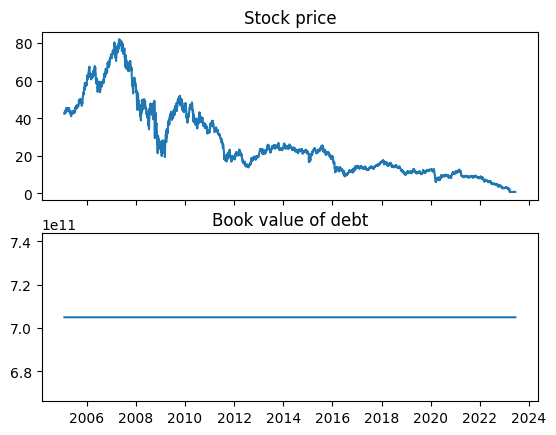

In [52]:
# ================================================================
#                        Plot the data
# ================================================================

def plot_stock_data(stock_data: pd.DataFrame) -> None:
    """
    Plot the stock data. 
    """

    # plot the closing price, the book value of debt in subplots
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].plot(stock_data.index, stock_data['Close'], label='Close')
    ax[0].set_title('Stock price')
    ax[1].plot(stock_data.index, stock_data['Book value of debt'], label='Book value of debt')
    ax[1].set_title('Book value of debt')
    plt.show()

plot_stock_data(stock_data)
